In [210]:
import pandas as pd
import seaborn as sns
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearTreeRegressor, LinearForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline

In [211]:
sklearn.__version__

'1.0.2'

# EDA (kinda?)

In [212]:
dataset = pd.read_csv('data/co2_dataset.csv')
dataset.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


<AxesSubplot:xlabel='Fuel Type', ylabel='count'>

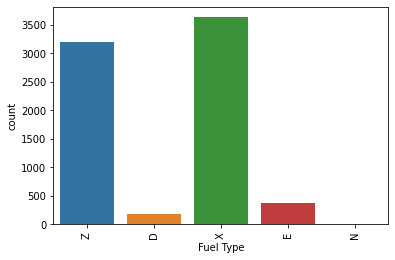

In [213]:
vc_plot = sns.countplot(x='Fuel Type', data=dataset)
vc_plot.set_xticklabels(vc_plot.get_xticklabels(), rotation=90)
vc_plot


In [214]:
dataset[dataset['Fuel Type'] == 'E'].count()

Make                                370
Model                               370
Vehicle Class                       370
Engine Size(L)                      370
Cylinders                           370
Transmission                        370
Fuel Type                           370
Fuel Consumption City (L/100 km)    370
Fuel Consumption Hwy (L/100 km)     370
Fuel Consumption Comb (L/100 km)    370
Fuel Consumption Comb (mpg)         370
CO2 Emissions(g/km)                 370
dtype: int64

In [215]:
dataset['Transmission'].nunique()

27

In [216]:
def preprocess_gearbox(row):
    if row['Transmission'] == 'AV':
        return ('AVinf', 0)

    starting_index = -1

    if row['Transmission'][-2].isdigit():
        starting_index = -2

    return (row['Transmission'][:starting_index], int(row['Transmission'][starting_index:]))

In [217]:
transmission = dataset.apply(preprocess_gearbox, axis=1, result_type='expand')
transmission.rename(columns={0: 'transmission_type', 1: 'gears'}, inplace=True)

In [218]:
transmission

,transmission_type,gears
0,AS,5
1,M,6
2,AV,7
3,AS,6
4,AS,6
...,...,...
7380,AS,8
7381,AS,8
7382,AS,8
7383,AS,8


In [219]:
preprocessed = dataset.join(transmission).drop(['Transmission'], axis=1)

In [220]:
preprocessed

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),transmission_type,gears
0,ACURA,ILX,COMPACT,2.0,4,Z,9.9,6.7,8.5,33,196,AS,5
1,ACURA,ILX,COMPACT,2.4,4,Z,11.2,7.7,9.6,29,221,M,6
2,ACURA,ILX HYBRID,COMPACT,1.5,4,Z,6.0,5.8,5.9,48,136,AV,7
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,Z,12.7,9.1,11.1,25,255,AS,6
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,Z,12.1,8.7,10.6,27,244,AS,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,Z,10.7,7.7,9.4,30,219,AS,8
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,Z,11.2,8.3,9.9,29,232,AS,8
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,Z,11.7,8.6,10.3,27,240,AS,8
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,Z,11.2,8.3,9.9,29,232,AS,8


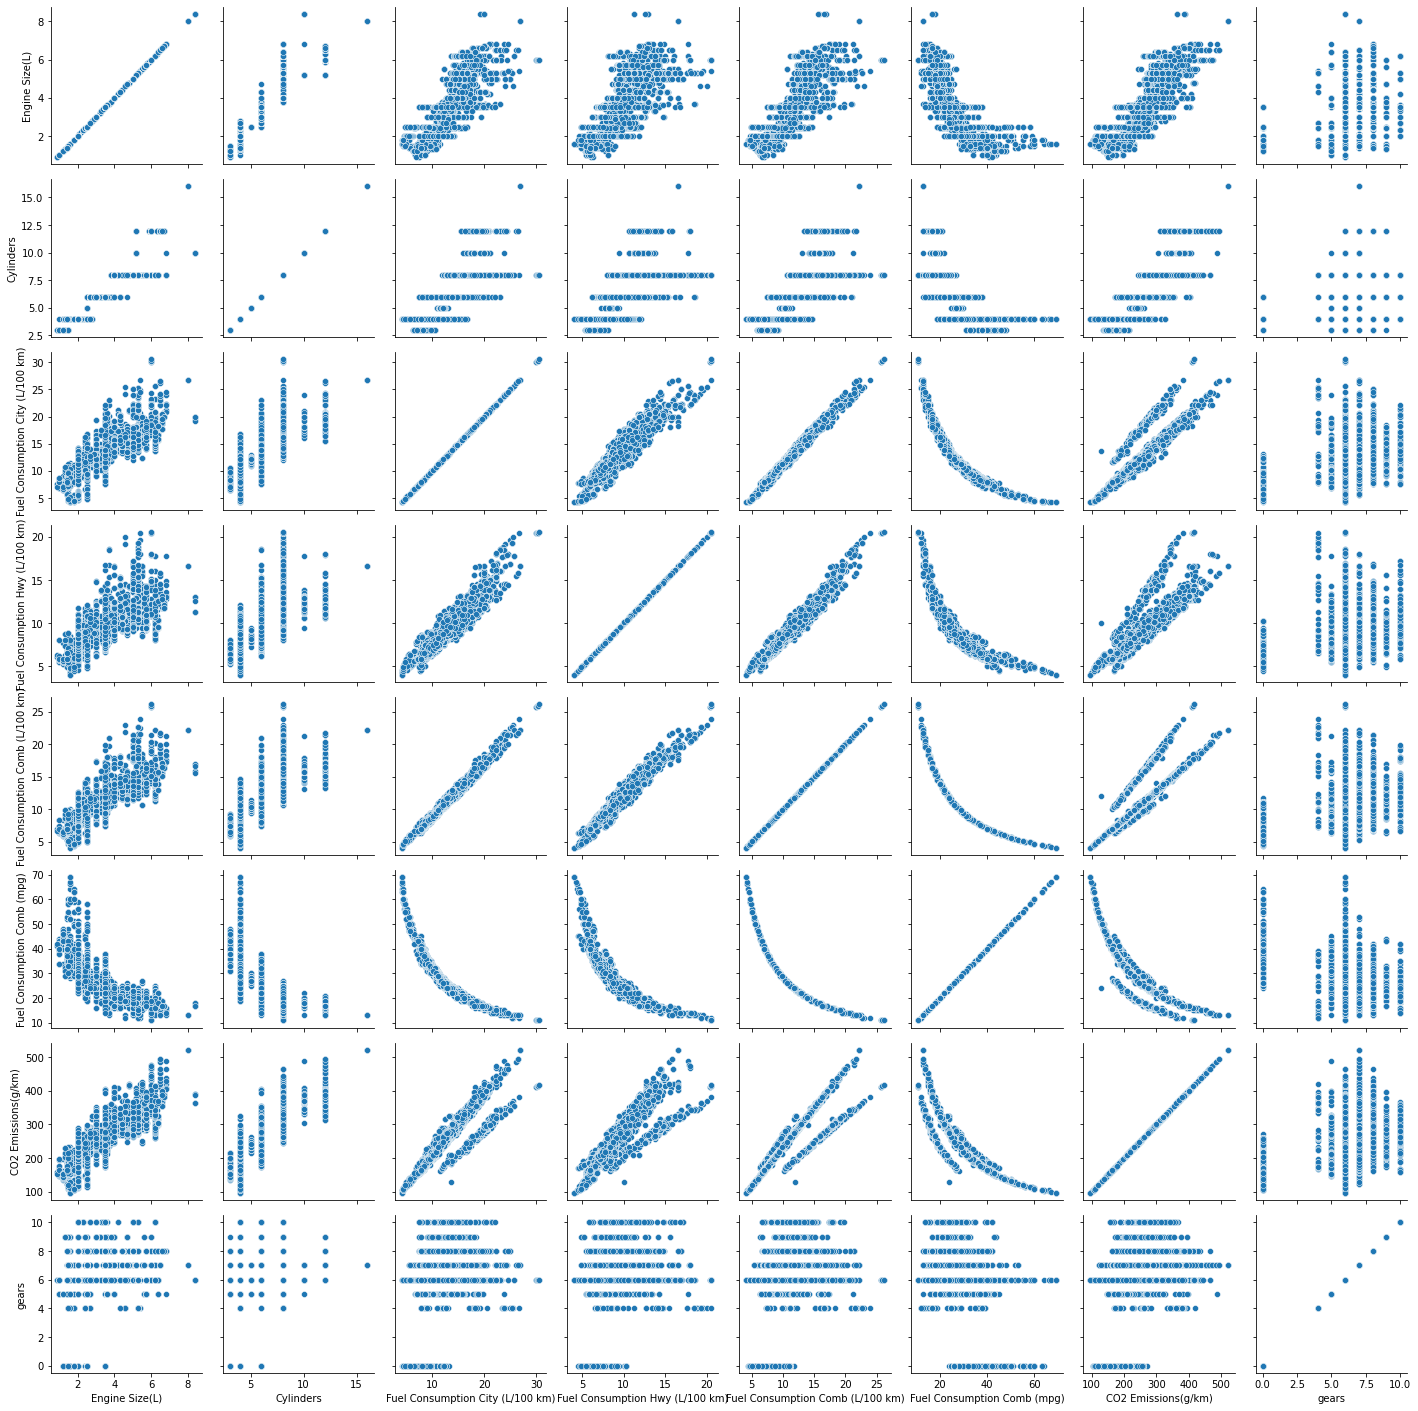

In [221]:
g = sns.PairGrid(data=preprocessed)
g.map(sns.scatterplot)

## Helpers

In [222]:
def make_dummies(dataset, column):
    dataset_preprocessed = pd.get_dummies(dataset[column], prefix=column)
    dataset_preprocessed = dataset_preprocessed.join(dataset).drop(column, axis=1)

    return dataset_preprocessed

In [223]:
def cross_val(X, y, model, k=10):
    kf = KFold(n_splits=k)

    R2_scores = []
    MSE = []
    MAE = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        R2_scores.append(model.score(X_test, y_test))
        MSE.append(mean_squared_error(y_test, pred) ** 0.5)
        MAE.append(mean_absolute_error(y_test, pred))

    print('R2 scores:')
    print(R2_scores)
    print(np.mean(R2_scores))
    print("MSE:")
    print(MSE)
    print(np.mean(MSE))
    print("MAE:")
    print(MAE)
    print(np.mean(MAE))

# Fuel -> CO2 regression

## Preprocessing

In [224]:
dataset = pd.read_csv('data/co2_dataset.csv')
dataset.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [225]:
dataset.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'],
      dtype='object')

In [226]:
dataset = dataset[['Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)', 'CO2 Emissions(g/km)']]

In [227]:
renamed_col = {
    'Make': 'producer',
    'Vehicle Class': 'vehicle_class',
    'Engine Size(L)': 'engine_size',
    'Transmission': 'transmission',
    'Cylinders': 'cylinders',
    'Fuel Type': 'fuel_type',
    'Fuel Consumption City (L/100 km)': 'fuel_cons',
    'CO2 Emissions(g/km)': 'co2'
}
dataset.rename(renamed_col, axis='columns', inplace=True)

dataset.head()

,producer,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons,co2
0,ACURA,COMPACT,2.0,4,AS5,Z,9.9,196
1,ACURA,COMPACT,2.4,4,M6,Z,11.2,221
2,ACURA,COMPACT,1.5,4,AV7,Z,6.0,136
3,ACURA,SUV - SMALL,3.5,6,AS6,Z,12.7,255
4,ACURA,SUV - SMALL,3.5,6,AS6,Z,12.1,244


In [228]:
def preprocess_fuel(row):
    type_map = {
        'X': 'gasoline',
        'Z': 'gasoline',
        'D': 'diesel',
        'E': 'other',
        'N': 'other'
    }

    row.fuel_type = type_map[row.fuel_type]

    return row

preprocessed = dataset.apply(preprocess_fuel, axis=1, result_type='expand')

In [229]:
co2_dataset = preprocessed[['fuel_type', 'fuel_cons', 'co2']]
co2_dataset.head()

,fuel_type,fuel_cons,co2
0,gasoline,9.9,196
1,gasoline,11.2,221
2,gasoline,6.0,136
3,gasoline,12.7,255
4,gasoline,12.1,244


<AxesSubplot:xlabel='fuel_cons', ylabel='co2'>

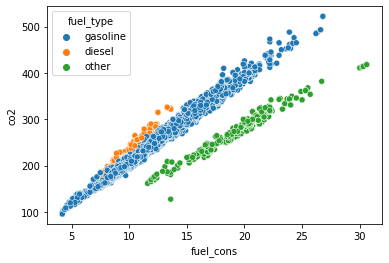

In [230]:
sns.scatterplot(data=co2_dataset, x="fuel_cons", y="co2", hue="fuel_type")

In [231]:
"""
co2_dataset_preprocessed = make_dummies(co2_dataset, 'fuel_type')
co2_dataset_X = co2_dataset_preprocessed.drop('co2', axis=1)
"""

fuel_one_hot = OneHotEncoder(sparse=False).fit(co2_dataset[['fuel_type']])
co2_dataset_fuel = fuel_one_hot.transform(co2_dataset[['fuel_type']])
co2_dataset_X = np.concatenate([co2_dataset_fuel, co2_dataset[['fuel_cons']]], axis=1)
co2_dataset_y = co2_dataset['co2']

In [232]:
co2_dataset_X, co2_dataset_y

(array([[ 0. ,  1. ,  0. ,  9.9],
        [ 0. ,  1. ,  0. , 11.2],
        [ 0. ,  1. ,  0. ,  6. ],
        ...,
        [ 0. ,  1. ,  0. , 11.7],
        [ 0. ,  1. ,  0. , 11.2],
        [ 0. ,  1. ,  0. , 12.2]]),
 0       196
 1       221
 2       136
 3       255
 4       244
        ... 
 7380    219
 7381    232
 7382    240
 7383    232
 7384    248
 Name: co2, Length: 7385, dtype: int64)

In [233]:
svr = make_pipeline(StandardScaler(), SVR(kernel='linear'))

cross_val(np.array(co2_dataset_X), np.array(co2_dataset_y), svr)

KeyboardInterrupt: 

In [234]:
linear_tree = LinearTreeRegressor(base_estimator=LinearRegression())
cross_val(np.array(co2_dataset_X), np.array(co2_dataset_y), linear_tree)

R2 scores:
[0.9774982117602365, 0.9766477154365094, 0.9847113760733407, 0.9846322792000896, 0.9853753348241, 0.9816010925182274, 0.9805578896918892, 0.9800139403086668, 0.9847595743910013, 0.9799764560789888]
0.9815773870283049
MSE:
[9.648241848137516, 8.933993810259455, 7.372755380090869, 6.743198976251977, 6.836620600122346, 7.959438170073918, 8.01380550344502, 7.635323761401628, 7.150783663885563, 8.586615038137548]
7.888077675180584
MAE:
[7.769249014022063, 7.251077437755703, 5.858208146566306, 5.177749365366521, 4.918969181458263, 5.443043116954607, 5.928611279826177, 5.647740392504023, 5.364855200294556, 6.4231479717140925]
5.978265110646232


In [235]:
linear_forrest = LinearForestRegressor(base_estimator=LinearRegression())
cross_val(np.array(co2_dataset_X), np.array(co2_dataset_y), linear_forrest)

R2 scores:
[0.9800334033118097, 0.9776450708287104, 0.985942730768369, 0.9848483787535198, 0.9862991322817816, 0.9836278665106433, 0.9816997420073371, 0.9812404409504082, 0.9850533816122206, 0.9804797030191453]
0.9826869850043944
MSE:
[9.088489029565286, 8.741130604697638, 7.069620594682456, 6.695619982363331, 6.617173928258913, 7.508255348550385, 7.774915945459029, 7.397333181399242, 7.081521284265232, 8.478025738230905]
7.645208563747241
MAE:
[7.455758341549888, 7.026938816255817, 5.658624862892175, 5.130851874127449, 4.766172078360908, 5.217138729601733, 5.628356607543607, 5.41375984952979, 5.3066996752982565, 6.24916480657361]
5.785346564173324


In [236]:
from joblib import dump, load

linear_tree.fit(np.array(co2_dataset_X), np.array(co2_dataset_y))
dump(linear_tree, 'joblib/co2_estimator.joblib')
dump(fuel_one_hot, 'joblib/fuel_one_hot.joblib')

['joblib/fuel_one_hot.joblib']

# Car specs -> Fuel consumption prediction

In [237]:
dataset['vehicle_class'].unique()

array(['COMPACT', 'SUV - SMALL', 'MID-SIZE', 'TWO-SEATER', 'MINICOMPACT',
       'SUBCOMPACT', 'FULL-SIZE', 'STATION WAGON - SMALL',
       'SUV - STANDARD', 'VAN - CARGO', 'VAN - PASSENGER',
       'PICKUP TRUCK - STANDARD', 'MINIVAN', 'SPECIAL PURPOSE VEHICLE',
       'STATION WAGON - MID-SIZE', 'PICKUP TRUCK - SMALL'], dtype=object)

## Preprocessing

In [238]:
def preprocess_gearbox(row):
    if row['transmission'] == 'AV':
        row['transmission_type'] = 'AVinf'
        row['gears'] = 0
    else:
        starting_index = -1

        if row['transmission'][-2].isdigit():
            starting_index = -2

        gearbox_type = row['transmission'][:starting_index]
        gearbox_type = 'M' if gearbox_type == 'M' else 'A'
        gears = int(row['transmission'][starting_index:])

        row['transmission_type'] = gearbox_type
        row['gears'] = gears

    return row

In [239]:
def preprocess_vehicle_class(row):
    if row['vehicle_class'] in ('VAN - CARGO', 'VAN - PASSENGER', 'PICKUP TRUCK - STANDARD', 'SPECIAL PURPOSE VEHICLE', 'MINIVAN', 'PICKUP TRUCK - SMALL'):
        type = 'cargo'
    elif row['vehicle_class'] in ('SUV - SMALL', 'SUV - STANDARD'):
        type = 'SUV'
    elif row['vehicle_class'] in ('COMPACT', 'MINICOMPACT', 'TWO-SEATER', 'SUBCOMPACT'):
        type = 'compact'
    else:
        type = 'full-size'
    row['vehicle_class'] = type

    return row

In [240]:
producers_other = dataset.groupby('producer').size() < 100

In [241]:
def preprocess_producer(row):
    if producers_other[row.producer]:
        row.producer = 'other'
        
    return row

In [242]:
fuel_dataset = dataset.apply(preprocess_fuel, axis=1, result_type='expand')
fuel_dataset = fuel_dataset.apply(preprocess_gearbox, axis=1, result_type='expand')
fuel_dataset = fuel_dataset.apply(preprocess_vehicle_class, axis=1, result_type='expand')
fuel_dataset = fuel_dataset.apply(preprocess_producer, axis=1, result_type='expand')

fuel_dataset = fuel_dataset.drop(['co2', 'cylinders', 'transmission'], axis=1)

In [243]:
fuel_dataset.producer.unique()

array(['other', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHEVROLET', 'DODGE',
       'FORD', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR', 'JEEP',
       'KIA', 'LEXUS', 'MAZDA', 'MERCEDES-BENZ', 'MINI', 'NISSAN',
       'PORSCHE', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO'], dtype=object)

In [244]:
fuel_dataset

,producer,vehicle_class,engine_size,fuel_type,fuel_cons,transmission_type,gears
0,other,compact,2.0,gasoline,9.9,A,5
1,other,compact,2.4,gasoline,11.2,M,6
2,other,compact,1.5,gasoline,6.0,A,7
3,other,SUV,3.5,gasoline,12.7,A,6
4,other,SUV,3.5,gasoline,12.1,A,6
...,...,...,...,...,...,...,...
7380,VOLVO,SUV,2.0,gasoline,10.7,A,8
7381,VOLVO,SUV,2.0,gasoline,11.2,A,8
7382,VOLVO,SUV,2.0,gasoline,11.7,A,8
7383,VOLVO,SUV,2.0,gasoline,11.2,A,8


In [245]:
"""
fuel_dataset_preprocessed = make_dummies(fuel_dataset, 'producer')
fuel_dataset_preprocessed = make_dummies(fuel_dataset_preprocessed, 'vehicle_class')
fuel_dataset_preprocessed = make_dummies(fuel_dataset_preprocessed, 'fuel_type')
fuel_dataset_preprocessed = make_dummies(fuel_dataset_preprocessed, 'transmission_type')
"""

producer_one_hot = OneHotEncoder(sparse=False).fit(fuel_dataset[['producer']])
fuel_dataset_producer = producer_one_hot.transform(fuel_dataset[['producer']])

vehicle_class_one_hot = OneHotEncoder(sparse=False).fit(fuel_dataset[['vehicle_class']])
fuel_dataset_vehicle_class = vehicle_class_one_hot.transform(fuel_dataset[['vehicle_class']])

fuel_dataset_fuel = fuel_one_hot.transform(fuel_dataset[['fuel_type']])

transmission_one_hot = OneHotEncoder(sparse=False).fit(fuel_dataset[['transmission_type']])
fuel_dataset_transmission = transmission_one_hot.transform(fuel_dataset[['transmission_type']])


fuel_dataset_X = np.concatenate([fuel_dataset_producer, fuel_dataset_vehicle_class, fuel_dataset_fuel, fuel_dataset_transmission, fuel_dataset[['engine_size', 'gears']]], axis=1)
fuel_dataset_y = fuel_dataset['fuel_cons']

In [246]:
fuel_dataset_X.shape

(7385, 37)

In [247]:
fuel_random_forrest = RandomForestRegressor()
cross_val(np.array(fuel_dataset_X), np.array(fuel_dataset_y), fuel_random_forrest)

R2 scores:
[0.9218258895973085, 0.9502915690323279, 0.9512546549281835, 0.9533511596463691, 0.9557575221216397, 0.9544109480648708, 0.9621638448076109, 0.9545322629524442, 0.9262623722897598, 0.9278093275865761]
0.945765955102709
MSE:
[1.2071339778855206, 0.7843068455789143, 0.7874236696111818, 0.7128016193990578, 0.6853315048578055, 0.6975803466745437, 0.6649197639535431, 0.6920444841142025, 0.8394627589825827, 0.9354690107488735]
0.8006473981806226
MAE:
[0.7622176498774934, 0.5203450796289348, 0.511937408896154, 0.4632994353435485, 0.4641816923249186, 0.45360331841334006, 0.4586262825165374, 0.4605515007325961, 0.5574395036025824, 0.6206781485900102]
0.5272880019926116


In [248]:
fuel_linear_forrest = LinearForestRegressor(base_estimator=LinearRegression())
cross_val(np.array(fuel_dataset_X), np.array(fuel_dataset_y), fuel_linear_forrest)

R2 scores:
[0.9397775427578426, 0.9486236997106303, 0.9518674408565503, 0.9546382196582937, 0.9551464750161963, 0.9543408489738342, 0.9621393580417866, 0.9547578087855623, 0.9260412929204436, 0.9364059277867502]
0.9483738614507888
MSE:
[1.0595055511851945, 0.7973562292723131, 0.7824585984041307, 0.7028996017989904, 0.6900479426670585, 0.6981164508833473, 0.6651348902133581, 0.6903258830524541, 0.8407202512854253, 0.8780053850215441]
0.7804570783783815
MAE:
[0.7099050005718586, 0.5134393135637669, 0.5097977868601686, 0.4668448180473392, 0.464905814672468, 0.4558100290827941, 0.4584252761540381, 0.4618035799564426, 0.5566236673537074, 0.5889275468584398]
0.5186482833121022


In [249]:
fuel_svr = SVR()
cross_val(np.array(fuel_dataset_X), np.array(fuel_dataset_y), fuel_svr)

R2 scores:
[0.8444781687956021, 0.8532248682463403, 0.8378023709988937, 0.8577153565827956, 0.8754727372325949, 0.840570396165464, 0.8548565302653218, 0.8792631153017801, 0.7844724772178338, 0.8426306604548449]
0.847048668126147
MSE:
[1.7026276471182853, 1.3477123793939116, 1.4363627754519783, 1.2448793603990427, 1.149775887705081, 1.3045130846417325, 1.3023103539901855, 1.1277227054322143, 1.4351861091885552, 1.3811756805503952]
1.3432265983871383
MAE:
[1.1310011601050807, 0.9253012730886718, 0.9660113230079914, 0.8880767491081597, 0.836895886433472, 0.8794962365402638, 0.8833297591109402, 0.8060388628192375, 0.9940237319793709, 0.9438192001320063]
0.9253994182325196


In [250]:
fuel_random_forrest.fit(np.array(fuel_dataset_X), np.array(fuel_dataset_y))
dump(fuel_random_forrest, 'joblib/fuel_estimator.joblib')
dump(producer_one_hot, 'joblib/producer_one_hot.joblib')
dump(vehicle_class_one_hot, 'joblib/vehicle_class_one_hot.joblib')
dump(transmission_one_hot, 'joblib/transmission_one_hot.joblib')

['joblib/transmission_one_hot.joblib']

# Medians

In [254]:
full_dataset = dataset.apply(preprocess_fuel, axis=1, result_type='expand')
full_dataset = full_dataset.apply(preprocess_gearbox, axis=1, result_type='expand')
full_dataset = full_dataset.apply(preprocess_vehicle_class, axis=1, result_type='expand')
full_dataset = full_dataset.apply(preprocess_producer, axis=1, result_type='expand')

full_dataset

,producer,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons,co2,transmission_type,gears
0,other,compact,2.0,4,AS5,gasoline,9.9,196,A,5
1,other,compact,2.4,4,M6,gasoline,11.2,221,M,6
2,other,compact,1.5,4,AV7,gasoline,6.0,136,A,7
3,other,SUV,3.5,6,AS6,gasoline,12.7,255,A,6
4,other,SUV,3.5,6,AS6,gasoline,12.1,244,A,6
...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,SUV,2.0,4,AS8,gasoline,10.7,219,A,8
7381,VOLVO,SUV,2.0,4,AS8,gasoline,11.2,232,A,8
7382,VOLVO,SUV,2.0,4,AS8,gasoline,11.7,240,A,8
7383,VOLVO,SUV,2.0,4,AS8,gasoline,11.2,232,A,8


In [258]:
personal_median = full_dataset[full_dataset['vehicle_class'] != 'cargo']['co2'].median()
cargo_median = full_dataset[full_dataset['vehicle_class'] == 'cargo']['co2'].median()

In [262]:
median_dict = {'personal': personal_median, 'cargo': cargo_median}
import json

with open('joblib/median.json', 'w') as f:
    json.dump(median_dict, f)